#**Slogan Persuasiveness**

## **Part A: Build a Predictive Model**

## **Imports and Data Preprocessing**

In [1]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import re

In [2]:
pip install langdetect

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from langdetect import detect

In [5]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])

    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)

            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)

    return X, Y, orig_Y

## **Ordinal Classifier (Baseline)**

In [7]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

        self.predictions = []

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape


        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model

    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]

        preds=np.array(preds)

        for data_point in range(len(preds[0])):


            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

In [8]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [9]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [10]:
def run(trainingFile, devFile, testFile, ordinal_values):

    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Accuracy for baseline method (blindly guessing one of 5 categories): 0.2")
    print(" ")
    print("Accuracy for baseline ordinal regression model:")
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

### **Baseline Ordinal Model Accuracy**

In [11]:
trainingFile = "../splits/train.txt"
devFile = "../splits/dev.txt"
testFile = "../splits/test.txt"

ordinal_values=["1", "2", "3", "4", "5"]

run(trainingFile, devFile, testFile, ordinal_values)

Accuracy for baseline method (blindly guessing one of 5 categories): 0.2
 
Accuracy for baseline ordinal regression model:
Test accuracy for best dev model: 0.430, 95% CIs: [0.333 0.527]



## **Improved Predictive Model**

### **Feature Engineering**

### Feature 1: Slogan Length

In [12]:
def slogan_length(text, max_len = 100):
  if len(text) > max_len:
    return False
  else:
    return True

### Feature 2: Punctuation

In [13]:
def punctuation(text):
  if "." in text:
    return False
  elif "!" in text or "?" in text:
    return True
  else:
    return False

### Feature 3: Readability

In [14]:
def readability(text):
  return all(c.isalnum() or c.isspace() for c in text)

### Feature 4: English

In [15]:
def english(text):
  try:
    return detect(text) == 'en'
  except:
    return False

### Feature 5: Rhyme

In [16]:
def get_ending_sounds(word):
  vowel_pattern = re.compile(r"[aeiouy]+[^aeiouy]*$", re.IGNORECASE)
  match = vowel_pattern.search(word)
  return match.group(0) if match else ""

def rhyme(text):
  words = text.split()

  ending_sounds = set()
  for word in words:
    if len(word) < 4:
      continue
    sound = get_ending_sounds(word)
    if sound in ending_sounds:
      return True
    else:
      ending_sounds.add(sound)
  return False

### Feature 6: Alliteration

In [17]:
def alliteration(text):
  words = text.lower().split()
  first_letters = [word[0] for word in words if word]
  alliteration_score = 1 if len(set(first_letters)) < len(first_letters) else 0
  if alliteration_score == 1:
    return True
  else:
    return False

### Feature 7: Action Words

In [18]:
def action_words(text):
  action_words = [
      'achieve', 'build', 'complete', 'develop', 'establish', 'improve',
      'increase', 'lead', 'manage', 'organize', 'perform', 'produce',
      'reduce', 'resolve', 'solve', 'start', 'upgrade'
  ]
  pattern = r'\b(' + '|'.join(action_words) + r')\b'

  if re.search(pattern, text, re.IGNORECASE):
      return True
  return False

### Feature 8: Compelling Words

In [19]:
def compelling(text):
  comp = {'new', 'free', 'save', 'love', 'best', 'world', 'forever', 'unmistakable', 'natural'}
  for w in comp:
    if w in text:
      return True
  return False

### Feature 9: Stop Words

In [20]:
def stopwords(text):
  count = 0
  stop_words = set(nltk.corpus.stopwords.words('english'))
  for stop in stop_words:
    if stop in text:
      count += 1
  if count > 5:
    return True
  else:
    return False

### Persuasiveness Features

In [21]:
def persuasiveness_features(text):
  features = {
      'length': slogan_length(text),
      'punctuation': punctuation(text),
      #'readability': readability(text),
      'english': english(text),
      'rhyme': rhyme(text),
      'alliteration': alliteration(text),
      'action_words': action_words(text),
      'compelling_words': compelling(text),
      #'stop_words': stopwords(text),
  }
  return features

In this section, we manually conducted feature selection in order to see which features were helping the model accurately classify models. Through this section, we found that features such as punctuation (whether a slogan had a ? or !) and readability (if all characters were numbers or letters) didn't help the model increase its accuracy. We also found that certain features such as rhyme and length were crucial in any iteration to help the model assess a slogan's persuasiveness.

### **Predictive Model Accuracy**

In [22]:
def run_predictive_model(trainingFile, devFile, testFile, ordinal_values):
    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, persuasiveness_features, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy = simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Accuracy for predictive ordinal model with feature engineering:")
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

In [23]:
run_predictive_model(trainingFile, devFile, testFile, ordinal_values)

Accuracy for predictive ordinal model with feature engineering:
Test accuracy for best dev model: 0.480, 95% CIs: [0.382 0.578]



## **Part B: Performance Analysis**

Our word analysis is attached as a pdf in the bcourses submission.

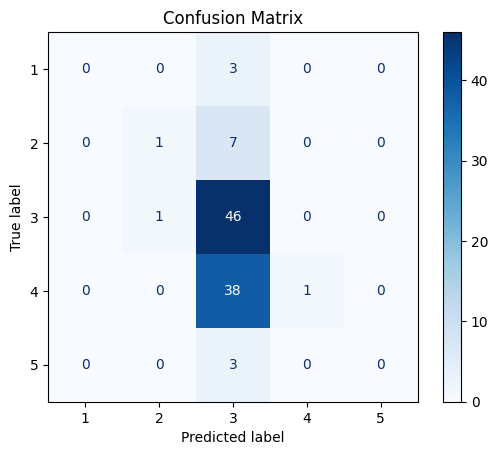

Most important features for classifying above vs below 2:
english: 0.1413
compelling_words: 0.0606
punctuation: 0.0518
action_words: 0.0069
length: -0.0000
alliteration: -0.0605
rhyme: -0.1790


Most important features for classifying above vs below 3:
english: 0.2789
rhyme: 0.1641
action_words: 0.0264
length: 0.0000
alliteration: -0.0080
compelling_words: -0.0349
punctuation: -0.3406


Most important features for classifying above vs below 4:
english: 0.2042
rhyme: 0.1812
alliteration: 0.0707
action_words: 0.0582
length: -0.0000
compelling_words: -0.0013
punctuation: -0.1713


Most important features for classifying above vs below 5:
alliteration: 0.3538
english: 0.1590
compelling_words: 0.1405
rhyme: 0.0776
length: 0.0000
action_words: -0.0096
punctuation: -0.0642




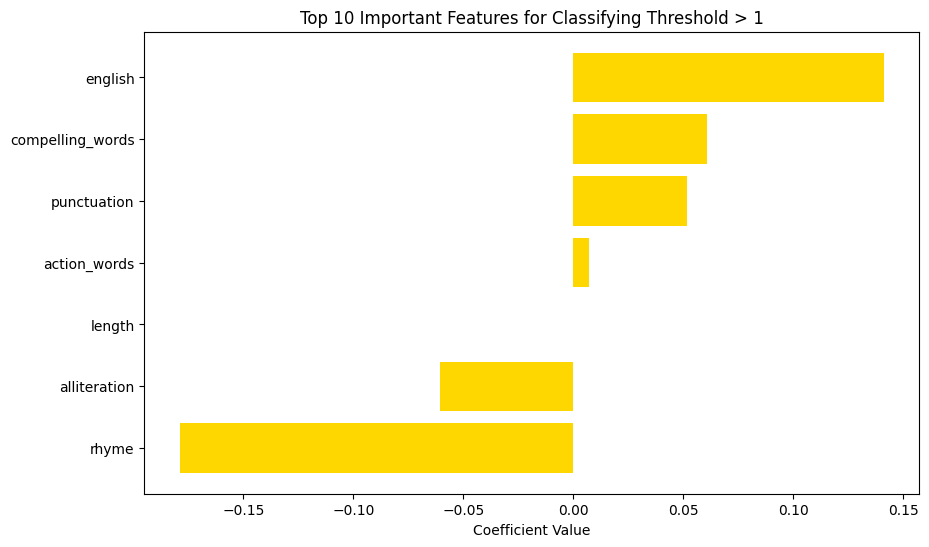

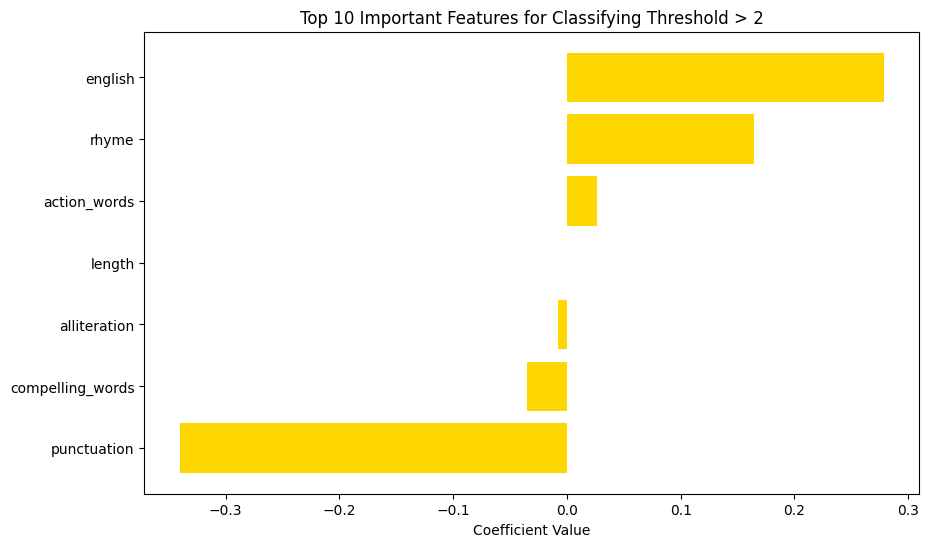

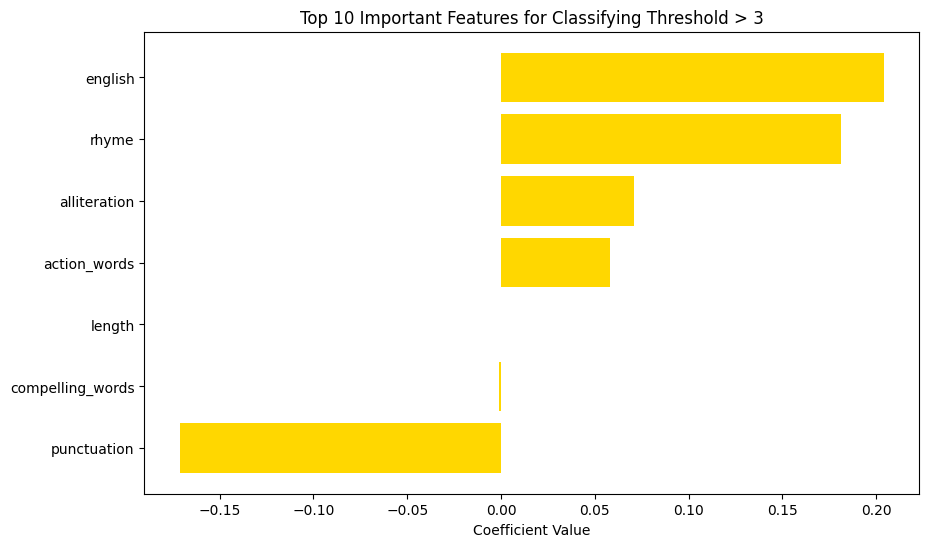

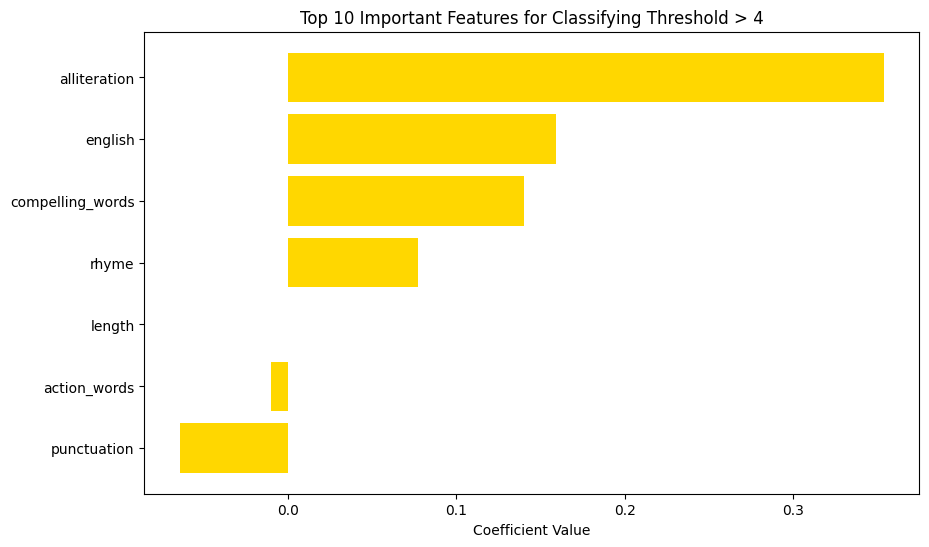

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import numpy as np

trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

simple_classifier = OrdinalClassifier(
    ordinal_values=["1", "2", "3", "4", "5"],
    feature_method=persuasiveness_features,
    trainX=trainX, trainY=trainY, devX=devX, devY=devY, testX=testX, testY=testY,
    orig_trainY=orig_trainY, orig_devY=orig_devY, orig_testY=orig_testY
)
simple_classifier.train()

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def feature_importance(classifier, feature_vocab):
    for idx, model in enumerate(classifier.log_regs):
        if model is not None:
            importance = model.coef_[0]
            features = {v: k for k, v in feature_vocab.items()}
            sorted_features = sorted(zip(importance, features.values()), reverse=True)
            print(f"Most important features for classifying above vs below {classifier.ordinal_values[idx + 1]}:")
            for imp, feat in sorted_features[:10]:
                print(f"{feat}: {imp:.4f}")
            print("\n")

def run_analysis(classifier):
    testX = classifier.testX
    orig_testY = classifier.orig_testY
    predictions = []
    for idx, ordinal_value in enumerate(classifier.ordinal_values[:-1]):
        proba = classifier.log_regs[idx].predict_proba(testX)[:, 1]
        predictions.append(proba)

    predictions = np.array(predictions)
    final_predictions = []

    for data_point in range(len(predictions[0])):
        ordinal_preds = np.zeros(len(classifier.ordinal_values))
        for ordinal in range(len(classifier.ordinal_values) - 1):
            if ordinal == 0:
                ordinal_preds[ordinal] = 1 - predictions[ordinal][data_point]
            else:
                ordinal_preds[ordinal] = predictions[ordinal - 1][data_point] - predictions[ordinal][data_point]
        ordinal_preds[len(classifier.ordinal_values) - 1] = predictions[len(predictions) - 1][data_point]
        prediction = np.argmax(ordinal_preds)
        final_predictions.append(classifier.ordinal_values[prediction])

    plot_confusion_matrix(orig_testY, final_predictions, classifier.ordinal_values)
    feature_importance(classifier, classifier.feature_vocab)

run_analysis(simple_classifier)


def plot_regression_coefficients(classifiers, feature_vocab):
    feature_names = [None] * len(feature_vocab)
    for feature, index in feature_vocab.items():
        if index < len(feature_names):
            feature_names[index] = feature

    for i, classifier in enumerate(classifiers):
        if classifier is not None:
            coefs = classifier.coef_[0]
            min_length = min(len(coefs), len(feature_names))
            indices = np.argsort(coefs)[-min_length:]

            plt.figure(figsize=(10, 6))
            plt.title(f"Top 10 Important Features for Classifying Threshold > {i+1}")
            plt.barh(range(len(indices)), coefs[indices], align='center', color='gold')
            plt.yticks(range(len(indices)), [feature_names[j] for j in indices])
            plt.xlabel("Coefficient Value")
            plt.show()

def regression_analysis(classifier, feature_vocab):
    if classifier.feature_vocab and classifier.log_regs:
        plot_regression_coefficients(classifier.log_regs, classifier.feature_vocab)
    else:
        print("Feature vocabulary or classifiers are not properly initialized.")

regression_analysis(simple_classifier, simple_classifier.feature_vocab)

